https://www.pymc-labs.com/blog-posts/markov-process/

In [286]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az

from itertools import product

In [287]:
import datetime as dt

In [288]:
df = pd.read_csv("../Data/raw/president_polls.csv")
#df = pd.read_csv("../Data/raw/president_polls_historical.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

In [289]:
df['state'].fillna("National", inplace=True)
df['state'] = df.merge(df_state[['state','state_code']])['state_code']

df['date'] = pd.to_datetime(df['end_date'])
#df = df[df['date'] >= '2024-01-01'] #Only polls since beginning of 2024
df['week'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days // 7 + 200
df = df.set_index('date')

df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_67686/1371373329.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['state'].fillna("National", inplace=True)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_67686/1371373329.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['end_date'])


In [290]:
z = pd.DataFrame()

z['state'] = df['state'].unique()

In [291]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

df = df.dropna()

In [292]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way["IND"] = 0
df_2way['OTH'] = 100 - (df_2way['DEM'] + df_2way['GOP'])
df_2way.loc[df_2way['OTH'] < 0, 'OTH'] = 0
df_2way['type'] = '2way'

In [293]:
df3 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden', 'Robert F. Kennedy'})

df_count = df3.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df3.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_3way = df_polls.merge(df_count)
df_3way = df_3way.rename(columns={'REP':'GOP'})
df_3way['OTH'] = 100 - (df_3way['DEM'] + df_3way['GOP'] + df_3way['IND'])
df_3way.loc[df_3way['OTH'] < 0, 'OTH'] = 0
df_3way['type'] = '3way'

In [294]:
df = pd.concat([df_2way, df_3way])
df['obs_id'] = range(len(df))
df = df.set_index('date')

# Define a function to map 'type' values to 'type_id'
def map_type_to_id(type_value):
    if type_value == '3way':
        return 1
    else:
        return 0

# Apply the function to create 'type_id' column
df['type_id'] = df['type'].apply(map_type_to_id)

In [295]:
df_2way[['DEM', 'GOP', 'OTH']].describe()

,DEM,GOP,OTH
count,738.000000,738.000000,738.000000
mean,43.773306,45.603252,10.623442
std,4.614137,4.708126,6.217813
min,25.000000,27.900000,0.000000
25%,42.000000,43.000000,7.000000
50%,43.000000,45.000000,11.650000
75%,46.000000,49.000000,14.000000
max,68.000000,60.600000,36.000000


In [296]:
df_3way[['DEM', 'GOP', 'IND', 'OTH']].describe()

,DEM,GOP,IND,OTH
count,118.000000,118.000000,118.000000,118.000000
mean,38.405085,41.417797,10.552542,9.633898
std,3.872053,4.467387,3.595741,5.662581
min,20.000000,27.000000,4.000000,0.000000
25%,37.000000,39.000000,8.000000,6.925000
50%,39.000000,42.000000,10.000000,9.300000
75%,41.000000,44.225000,13.000000,12.000000
max,48.000000,50.600000,21.000000,25.000000


In [297]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(10).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(10).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

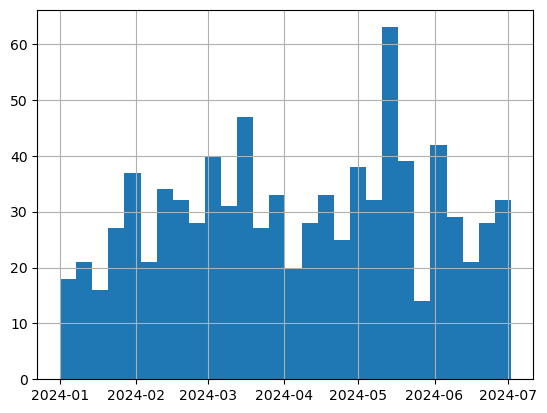

In [298]:
df.reset_index()["date"].hist(bins=len(df.week.unique()))
plt.show()

In [299]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone/Text-to-Web,Live Phone,Probability Panel,IVR/Online Panel,IVR/Text-to-Web,Online Panel/Text-to-Web,IVR/Online Panel/Text-to-Web,Live Phone/Online Panel/Text-to-Web,IVR/Online Panel/Email
pollster,,,,,,,,,,,
All,856,412,63,61,60,40,39,27,20,17,16
Morning Consult,223,223,0,0,0,0,0,0,0,0,0
Florida Atlantic University/Mainstreet Research,66,0,0,0,0,28,34,0,0,0,0
Emerson,54,0,0,0,0,8,0,1,19,0,16
YouGov,42,42,0,0,0,0,0,0,0,0,0
Ipsos,39,0,0,0,39,0,0,0,0,0,0
Siena/NYT,22,0,0,22,0,0,0,0,0,0,0
Big Data Poll,21,0,0,0,0,0,0,0,0,6,0
Beacon/Shaw,18,0,17,1,0,0,0,0,0,0,0


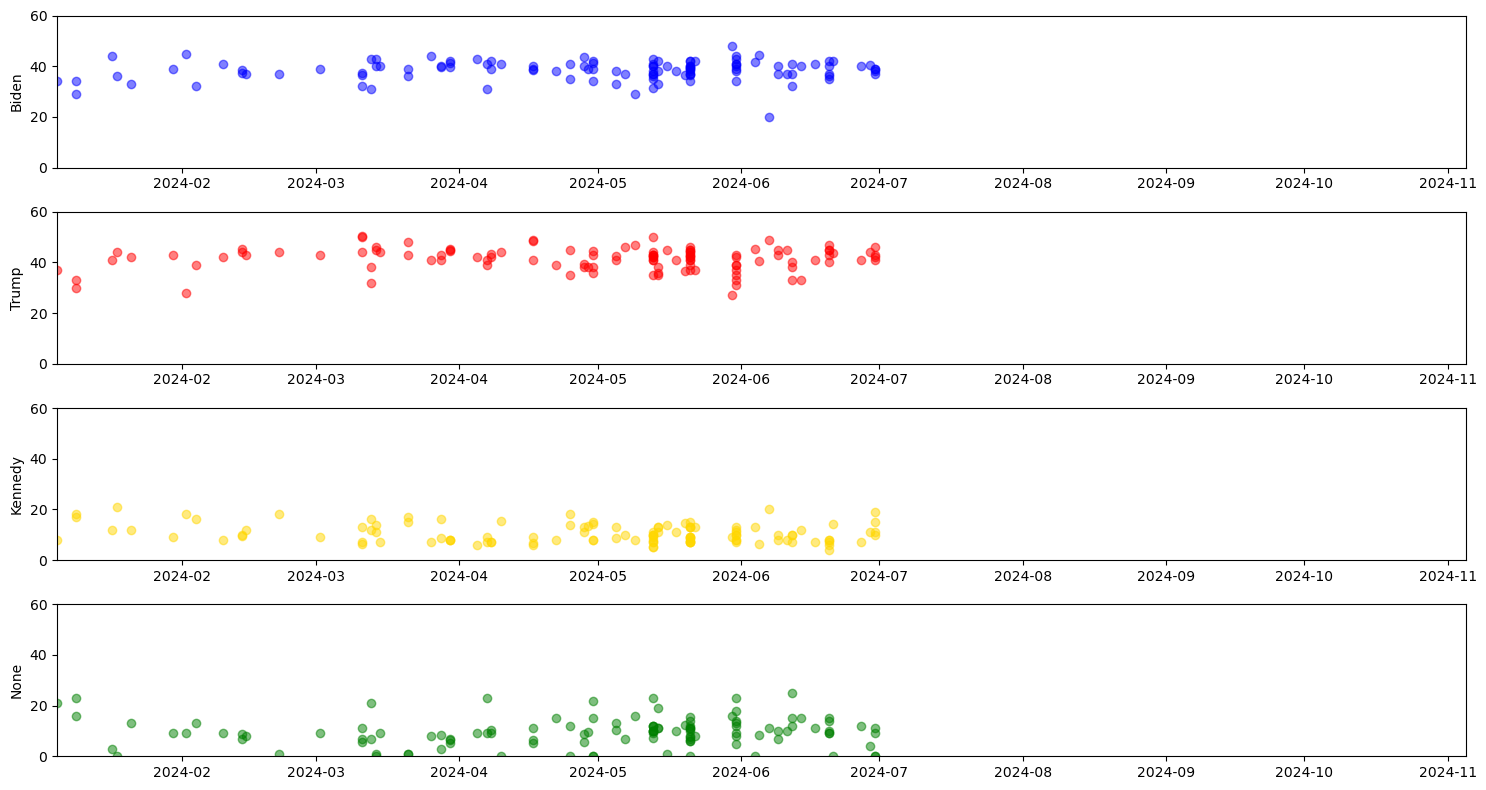

In [301]:
dem_votes = df_3way["DEM"].values
gop_votes = df_3way["GOP"].values
ind_votes = df_3way["IND"].values
oth_votes = df_3way["OTH"].values

dates = df_3way.set_index('date').index

fig, axes = plt.subplots(4, figsize=(15, 8))
for ax, rate, label, color in zip(
    axes.ravel(),
    [dem_votes, gop_votes, ind_votes, oth_votes],
    ["Biden", "Trump", "Kennedy", "None"],
    ['blue', 'red', 'gold', 'green']
):
    ax.plot(dates, rate, "o", alpha=0.5, color=color)
    ax.set_ylim(0, 60)
    ax.set_xlim(dt.datetime(2024, 1, 5), dt.datetime(2024, 11, 5))
    ax.set_ylabel(label)
    
plt.tight_layout()

plt.show()

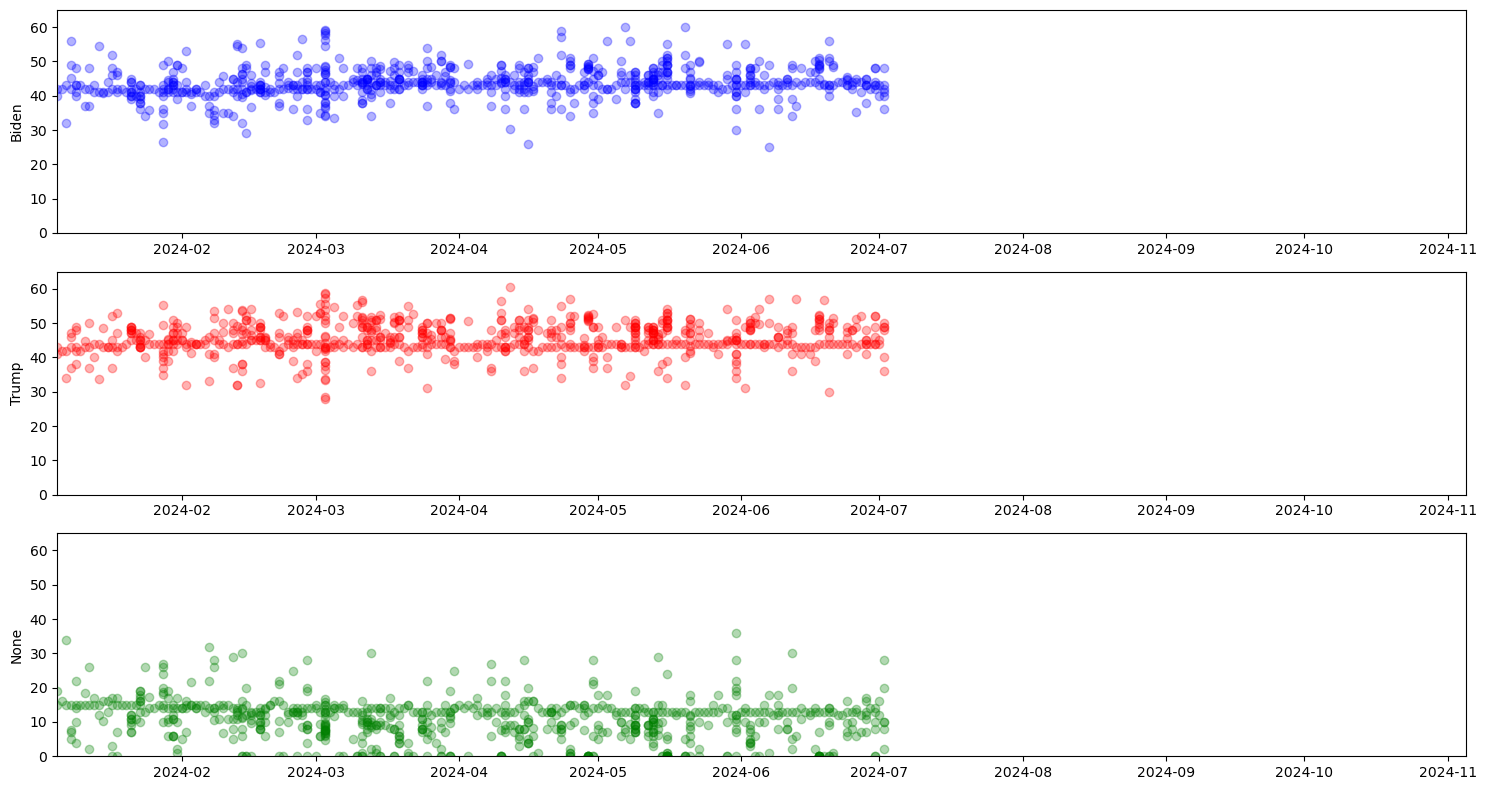

In [302]:
dem_votes = df_2way["DEM"].values
gop_votes = df_2way["GOP"].values
oth_votes = df_2way["OTH"].values

dates = df_2way.set_index('date').index

fig, axes = plt.subplots(3, figsize=(15, 8))
for ax, rate, label, color in zip(
    axes.ravel(),
    [dem_votes, gop_votes, oth_votes],
    ["Biden", "Trump", "None"],
    ['blue', 'red', 'green']
):
    ax.plot(dates, rate, "o", alpha=0.3, color=color)
    ax.set_ylim(0, 65)
    ax.set_xlim(dt.datetime(2024, 1, 5), dt.datetime(2024, 11, 5))
    ax.set_ylabel(label)
    
plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'Monthly standard deviation in polls')

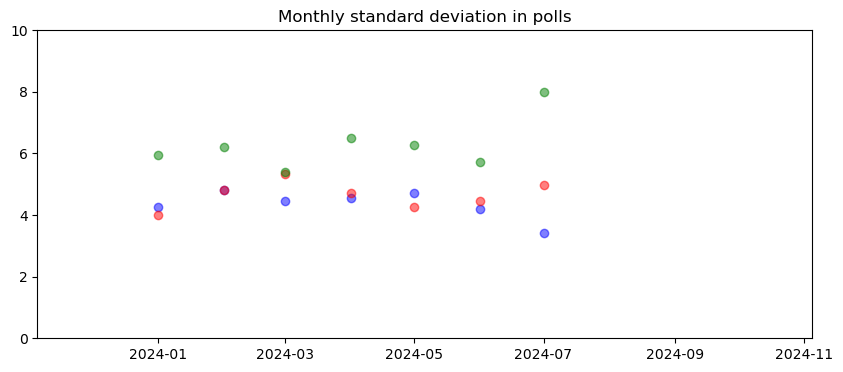

In [303]:
rolling_std = (
    df_2way[["year", "month", "DEM", "GOP", "OTH"]]
    .reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "DEM", "GOP", "OTH"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.DEM.values,
    "o",
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.GOP.values,
    "o",
    color = 'red',
    alpha=0.5,
)

ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.OTH.values,
    "o",
    color = 'green',
    alpha=0.5,
)

ax.set_ylim(0, 10)
ax.set_xlim(dt.datetime(2023, 11, 5), dt.datetime(2024, 11, 5))
ax.set_title("Monthly standard deviation in polls")

Text(0.5, 1.0, 'Monthly standard deviation in polls')

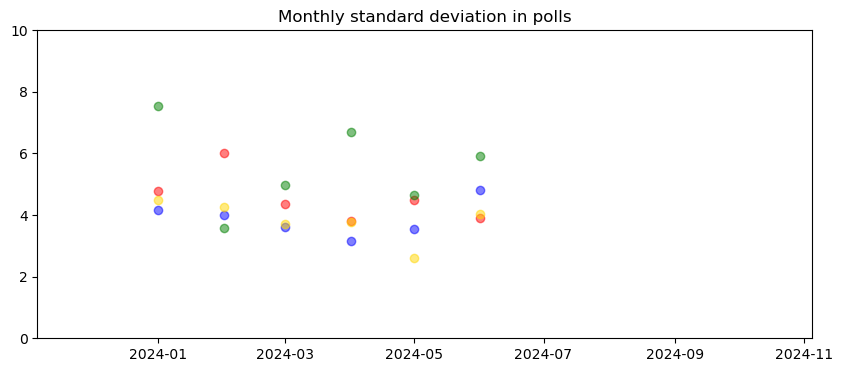

In [304]:
rolling_std = (
    df_3way[["year", "month", "DEM", "GOP", "IND", "OTH"]]
    .reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "DEM", "GOP", "IND", "OTH"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.DEM.values,
    "o",
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.GOP.values,
    "o",
    color = 'red',
    alpha=0.5,
)
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.IND.values,
    "o",
    color = 'gold',
    alpha=0.5,
)
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.OTH.values,
    "o",
    color = 'green',
    alpha=0.5,
)

ax.set_ylim(0, 10)
ax.set_xlim(dt.datetime(2023, 11, 5), dt.datetime(2024, 11, 5))
ax.set_title("Monthly standard deviation in polls")

We can see here that the polling methodology does not affect the Dem's mean performance however it drastically affects Trump, Kennedy, and other responses.

In [305]:
df.query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'App Panel']")[['methodology','DEM','GOP','IND','OTH']].groupby("methodology").mean()

,DEM,GOP,IND,OTH
methodology,,,,
App Panel,45.207692,49.415385,5.384615,0.000000
Live Phone,42.585246,46.245902,1.539344,9.629508
Online Panel,42.826699,44.648786,0.887379,11.639563
Probability Panel,42.016667,40.300000,2.616667,15.066667


We can see that Trump fairly consistently out-performs on Live Phone polls. These polls are rarer because they are more expensive however are often seen as higher quality.

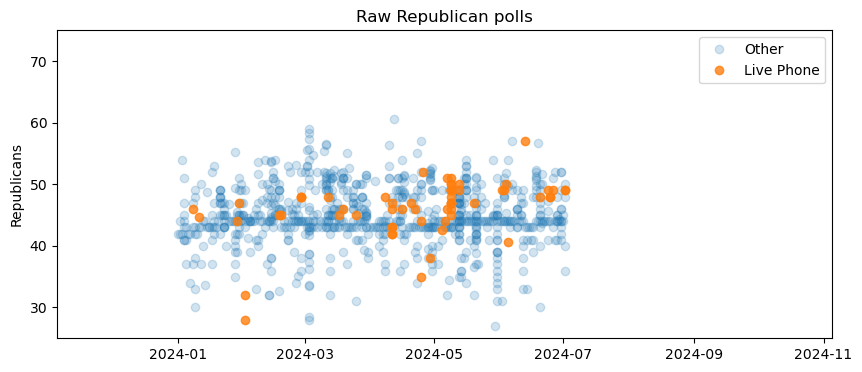

In [306]:
face = df[df["methodology"] == "Live Phone"]
dates_face = face.index

other = df[df["methodology"] != "Live Phone"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["GOP"].values, "o", alpha=0.2, label="Other")
ax.plot(dates_face, face["GOP"].values, "o", alpha=.8, label="Live Phone")
ax.set_ylim(0, 100)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_ylim(25, 75)
ax.set_xlim(dt.datetime(2023, 11, 5), dt.datetime(2024, 11, 5))
ax.legend()

In [307]:
df["margin"] = df["DEM"]-df["GOP"]

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "IND", "OTH", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [308]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]
df["diff_IND"] = df["IND"] - df["IND_mean"]
df["diff_OTH"] = df["OTH"] - df["OTH_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,GOP_mean,DEM_mean,IND_mean,OTH_mean,margin_mean,diff_GOP,diff_DEM,diff_IND,diff_OTH,diff_margin
0,2024-07-02,87297,201890,241,Ipsos,Probability Panel,US,rv,892.0,2024,...,45.33,41.67,0.00,13.00,-3.67,-5.33,-1.67,0.00,7.00,3.67
1,2024-07-02,87297,202061,241,Ipsos,Probability Panel,US,a,1070.0,2024,...,45.33,41.67,0.00,13.00,-3.67,-9.33,-5.67,0.00,15.00,3.67
2,2024-07-02,87303,202024,1822,Fabrizio/GBAO,Live Phone/Text-to-Web,US,rv,1500.0,2024,...,45.33,41.67,0.00,13.00,-3.67,2.67,0.33,0.00,-3.00,-2.33
3,2024-07-02,87299,201938,568,YouGov,Online Panel,US,lv,2815.0,2024,...,45.33,41.67,0.00,13.00,-3.67,4.67,6.33,0.00,-11.00,1.67
4,2024-07-02,87302,202014,1424,Siena/NYT,Live Phone,US,rv,1532.0,2024,...,45.33,41.67,0.00,13.00,-3.67,3.67,-0.67,0.00,-3.00,-4.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,2024-01-09,85585,190223,241,Ipsos,Probability Panel,US,a,4677.0,2024,...,31.50,31.50,17.50,19.50,0.00,-1.50,-2.50,0.50,3.50,-1.00
852,2024-01-09,85585,190481,241,Ipsos,Probability Panel,US,rv,3815.0,2024,...,31.50,31.50,17.50,19.50,0.00,1.50,2.50,-0.50,-3.50,1.00
853,2024-01-05,85586,190225,770,TIPP,Online Panel,US,rv,1247.0,2024,...,39.67,35.00,9.67,15.67,-4.67,-2.67,-1.00,-1.67,5.33,1.67
854,2024-01-04,85587,190228,1800,Noble Predictive Insights,Online Panel/Text-to-Web,US,lv,2364.0,2024,...,39.67,35.00,9.67,15.67,-4.67,1.33,1.00,0.33,-2.67,-0.33


Trump has a much greater lead in a three-way race:

In [309]:
df.groupby('type')[['margin']].mean()

,margin
type,
2way,-1.829946
3way,-3.012712


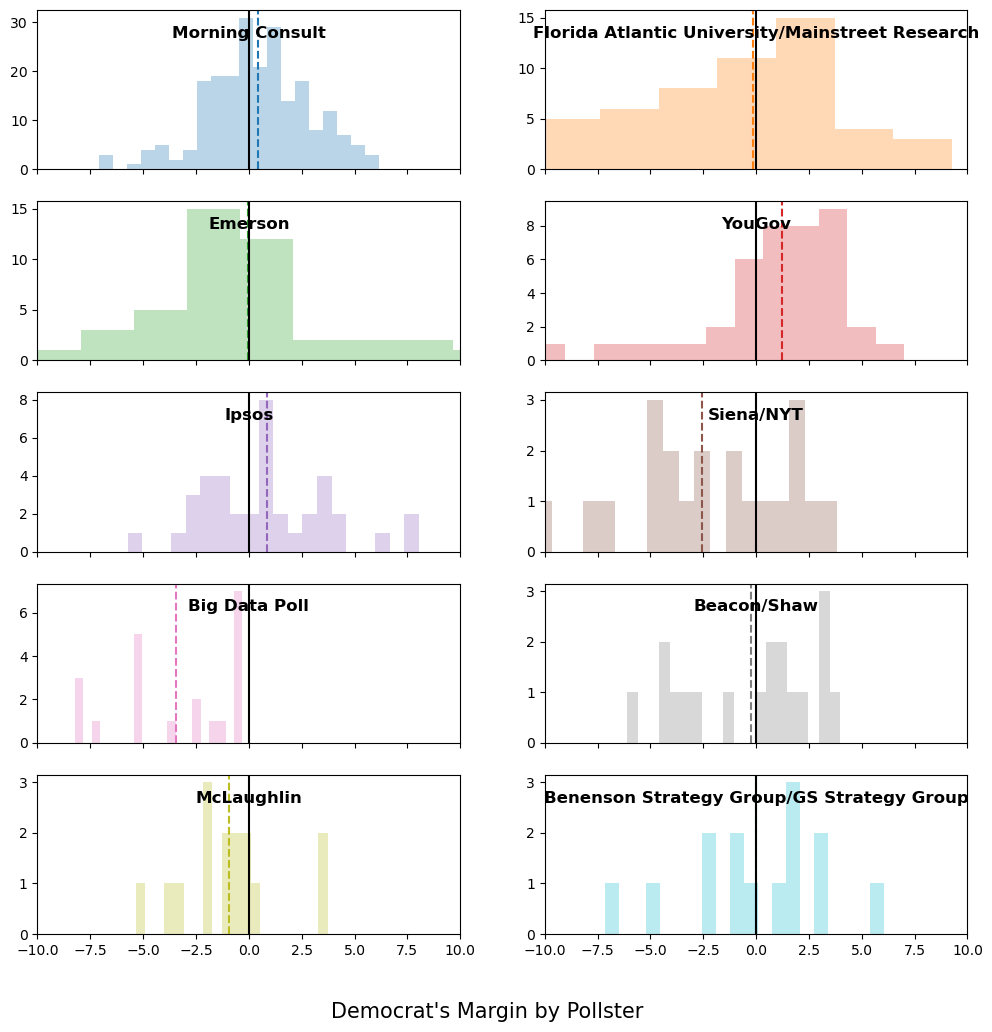

In [310]:
POLLSTER_VALS = {
    pollster: df[df["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-10, 10)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

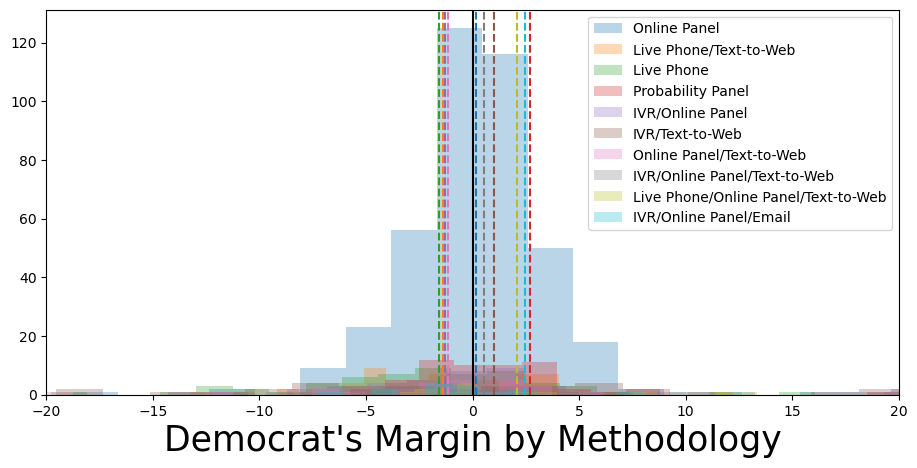

In [311]:
METHOD_VALS = {
    method: df[df["methodology"] == method]["diff_margin"].values
    for method in METHODS_top
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method, bins=25)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-20, 20)
ax.set_xlabel(r"Democrat's Margin by Methodology", fontsize=25)
ax.legend();

In [312]:
df

,date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,GOP_mean,DEM_mean,IND_mean,OTH_mean,margin_mean,diff_GOP,diff_DEM,diff_IND,diff_OTH,diff_margin
0,2024-07-02,87297,201890,241,Ipsos,Probability Panel,US,rv,892.0,2024,...,45.333333,41.666667,0.000000,13.000000,-3.666667,-5.333333,-1.666667,0.000000,7.000000,3.666667
1,2024-07-02,87297,202061,241,Ipsos,Probability Panel,US,a,1070.0,2024,...,45.333333,41.666667,0.000000,13.000000,-3.666667,-9.333333,-5.666667,0.000000,15.000000,3.666667
2,2024-07-02,87303,202024,1822,Fabrizio/GBAO,Live Phone/Text-to-Web,US,rv,1500.0,2024,...,45.333333,41.666667,0.000000,13.000000,-3.666667,2.666667,0.333333,0.000000,-3.000000,-2.333333
3,2024-07-02,87299,201938,568,YouGov,Online Panel,US,lv,2815.0,2024,...,45.333333,41.666667,0.000000,13.000000,-3.666667,4.666667,6.333333,0.000000,-11.000000,1.666667
4,2024-07-02,87302,202014,1424,Siena/NYT,Live Phone,US,rv,1532.0,2024,...,45.333333,41.666667,0.000000,13.000000,-3.666667,3.666667,-0.666667,0.000000,-3.000000,-4.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,2024-01-09,85585,190223,241,Ipsos,Probability Panel,US,a,4677.0,2024,...,31.500000,31.500000,17.500000,19.500000,0.000000,-1.500000,-2.500000,0.500000,3.500000,-1.000000
852,2024-01-09,85585,190481,241,Ipsos,Probability Panel,US,rv,3815.0,2024,...,31.500000,31.500000,17.500000,19.500000,0.000000,1.500000,2.500000,-0.500000,-3.500000,1.000000
853,2024-01-05,85586,190225,770,TIPP,Online Panel,US,rv,1247.0,2024,...,39.666667,35.000000,9.666667,15.666667,-4.666667,-2.666667,-1.000000,-1.666667,5.333333,1.666667
854,2024-01-04,85587,190228,1800,Noble Predictive Insights,Online Panel/Text-to-Web,US,lv,2364.0,2024,...,39.666667,35.000000,9.666667,15.666667,-4.666667,1.333333,1.000000,0.333333,-2.666667,-0.333333


In [314]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "population": population,
    "week": week,
    "observation": df.obs_id
}

In [316]:
with pm.Model(coords=COORDS) as pooled_popularity_simple:

    dem_sigma = pm.LogNormal("dem_sigma", mu=-3, sigma=1)
    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.1, dims="pollster")
    dem_method_effect = pm.Normal("dem_method_effect", 0, 0.1, dims="method")
    dem_state_effect = pm.Normal("dem_state_effect", 0, 0.1, dims="state")
    dem_pop_effect = pm.Normal("dem_pop_effect", 0, 0.1, dims="population")
    dem_week_effect = pm.GaussianRandomWalk("dem_week_effect", sigma=dem_sigma, init_dist=pm.Normal.dist(mu=0, sigma=0.1), dims="week")
    dem_3way = pm.Normal("dem_3way", 0, 0.1)

    gop_sigma = pm.LogNormal("gop_sigma", mu=-3, sigma=1)
    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.1, dims="pollster")
    gop_method_effect = pm.Normal("gop_method_effect", 0, 0.1, dims="method")
    gop_state_effect = pm.Normal("gop_state_effect", 0, 0.1, dims="state")
    gop_pop_effect = pm.Normal("gop_pop_effect", 0, 0.1, dims="population")
    gop_week_effect = pm.GaussianRandomWalk("gop_week_effect", sigma=0.1, init_dist=pm.Normal.dist(mu=0, sigma=0.1), dims="week")
    gop_3way = pm.Normal("gop_3way", 0, 0.1)

    ind_sigma = pm.LogNormal("ind_sigma", mu=-3, sigma=1)
    ind_pollster_effect = pm.Normal("ind_pollster_effect", 0, 0.1, dims="pollster")
    ind_method_effect = pm.Normal("ind_method_effect", 0, 0.1, dims="method")
    ind_state_effect = pm.Normal("ind_state_effect", 0, 0.1, dims="state")
    ind_pop_effect = pm.Normal("ind_pop_effect", 0, 0.1, dims="population")
    ind_week_effect = pm.GaussianRandomWalk("ind_week_effect", sigma=.1, init_dist=pm.Normal.dist(mu=0, sigma=0.1), dims="week")

    type_race = pm.Data("type_race", df['type_id'])

    dem_polling = (1 + dem_3way * type_race) * pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_state_effect[state_id] +
        dem_pop_effect[population_id] +
        dem_week_effect[week_id]
    )

    gop_polling = (1 + gop_3way * type_race) * pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_state_effect[state_id] +
        gop_pop_effect[population_id] +
        gop_week_effect[week_id]
    )

    ind_polling = type_race * pm.math.invlogit(
        ind_pollster_effect[pollster_id] +
        ind_method_effect[method_id] +
        ind_state_effect[state_id] +
        ind_pop_effect[population_id] +
        ind_week_effect[week_id]
    )

    dem_vote = pm.Binomial(
        "dem_vote",
        p=dem_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['DEM'] / 100,
        dims="observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p=gop_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['GOP'] / 100,
        dims="observation",
    )

    ind_vote = pm.Binomial(
        "ind_vote",
        p=ind_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['IND'] / 100,
        dims="observation",
    )

    idata = pm.sample(draws=100, cores=14, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (14 chains in 14 jobs)
NUTS: [dem_sigma, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_pop_effect, dem_week_effect, dem_3way, gop_sigma, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_pop_effect, gop_week_effect, gop_3way, ind_sigma, ind_pollster_effect, ind_method_effect, ind_state_effect, ind_pop_effect, ind_week_effect]
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pytensor/compile/function/types.py:1138: UserWarning: aliased relationship between Function arguments 28, 28 will not be preserved by un-pickling operation
  warnings.warn(


Output()

Sampling 14 chains for 1_000 tune and 100 draw iterations (14_000 + 1_400 draws total) took 470 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [127]:
# Sample posterior predictive for out-of-sample predictions
posterior_predictive = pm.sample_posterior_predictive(idata, model=pooled_popularity_simple).assign_coords(COORDS)

Sampling: [dem_vote, gop_vote, ind_vote, oth_vote]


Output()

In [420]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [421]:
states = df['state'].unique()
parties = ['dem', 'gop', 'ind', 'margin']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [422]:
df_results = pd.DataFrame(columns=combinations)

In [423]:
for state in states:
    for party in parties[:2]:
        df_results[f"{state}_{party}"] = ((1 + idata.posterior[f"{party}_3way"]) * inv_logit(idata.posterior[f"{party}_pollster_effect"].mean(axis=2) +
#        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].mean(axis=2) +                                                                                            
        idata.posterior[f"{party}_state_effect"].mean(axis=0).sel(state=f"{state}") +
        idata.posterior[f"{party}_pop_effect"].mean(axis=0).sel(population="lv") + #Likely votes
        idata.posterior[f"{party}_week_effect"].mean(axis=0).sel(week=182))).values.ravel()

    for party in ['ind']:
        df_results[f"{state}_{party}"] = (inv_logit(idata.posterior[f"{party}_pollster_effect"].mean(axis=2) +
#        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].mean(axis=2) +                                                                                            
        idata.posterior[f"{party}_state_effect"].mean(axis=0).sel(state=f"{state}") +
        idata.posterior[f"{party}_pop_effect"].mean(axis=0).sel(population="lv") + #Likely votes
        idata.posterior[f"{party}_week_effect"].mean(axis=0).sel(week=182))).values.ravel()

    df_results[f"{state}_margin"] = df_results[f"{state}_dem"] - df_results[f"{state}_gop"]

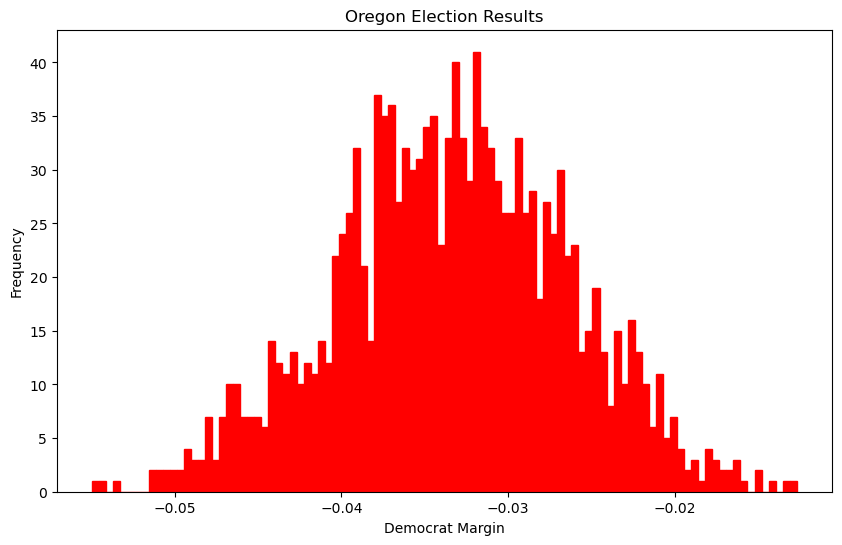

In [424]:
# Plotting the histograms
plt.figure(figsize=(10, 6))

ax = df_results['WI_margin'].plot.hist(bins = 100)

for bar in ax.containers[0]:
    # get x midpoint of bar
    x = bar.get_x() + 0.5 * bar.get_width()

    # set bar color based on x
    if x < 0:
        bar.set_color('red')
    elif x > 0:
        bar.set_color('blue')
    else:
        bar.set_color('green')

# Adding titles and labels
plt.title('Oregon Election Results')
plt.xlabel('Democrat Margin')
plt.ylabel('Frequency')

# Display the plot
plt.show()


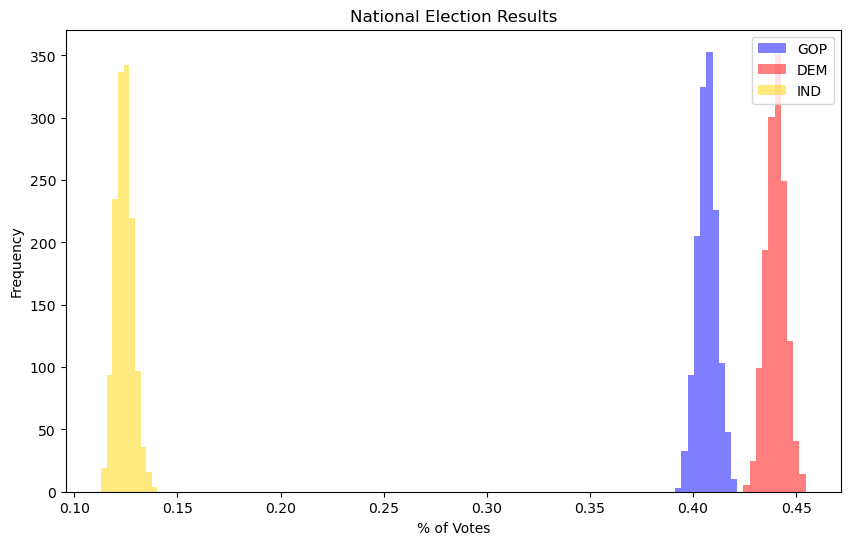

In [425]:
# Plotting the histograms
plt.figure(figsize=(10, 6))

plt.hist(df_results['WI_dem'], bins=10, alpha=0.5, color='blue', label='GOP')
plt.hist(df_results['WI_gop'], bins=10, alpha=0.5, color='red', label='DEM')
plt.hist(df_results['WI_ind'], bins=10, alpha=0.5, color='gold', label='IND')

# Adding titles and labels
plt.title('National Election Results')
plt.xlabel('% of Votes')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Display the plot
plt.show()


In [426]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    ind_votes = df_results[f"{state}_ind"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > max(gop_votes[i], ind_votes[i])
         else "gop" if gop_votes[i] > max(dem_votes[i], ind_votes[i])
         else "ind" if ind_votes[i] > max(dem_votes[i], gop_votes[i])
         else "tie"
         for i in range(len(df_results))]
    )

In [412]:
df_margin = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]

In [413]:
df_margin.mean().sort_values()

UT     -0.220924
SD     -0.219762
OK     -0.190711
NE     -0.185285
TN     -0.158715
MT     -0.156392
MO     -0.138477
SC     -0.136202
AL     -0.124358
IN     -0.123637
OH     -0.117402
AK     -0.107397
TX     -0.106783
FL     -0.103220
LA     -0.086142
IA     -0.082574
GA     -0.074137
NC     -0.069325
NV     -0.062404
AZ     -0.057612
ME     -0.052768
MI     -0.042542
PA     -0.037396
WI     -0.033355
US     -0.032266
NE-2   -0.023454
NM     -0.021901
VA     -0.004138
NH     -0.003309
OR     -0.000269
NJ      0.000035
MN      0.001453
HI      0.023037
CO      0.033972
RI      0.033981
WA      0.050460
NY      0.050516
VT      0.053800
CA      0.145151
MD      0.154171
MA      0.157162
dtype: float64

In [ ]:
az.plot_trace(idata);

In [ ]:
idata.posterior

In [ ]:
dem_polling = (1 + idata.posterior.dem_3way.mean(axis=0)) * pm.math.invlogit(
        idata.posterior.dem_pollster_effect.mean(axis=0).mean(axis=1) +
        idata.posterior.dem_method_effect.mean(axis=0).mean(axis=1) +
#        dem_state_effect[state_id] +
        idata.posterior.dem_pop_effect.mean(axis=0).mean(axis=1) +
        idata.posterior.dem_week_effect.mean(axis=0).sel(week=182)
    )

In [ ]:
dem_week_effect_max_week = idata.posterior.dem_week_effect.sel(week=max_week)

NameError: name 'idata' is not defined

In [1200]:
idata.posterior.dem_week_effect.mean(axis=0).mean(axis=0).values

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [1202]:
df_post = pd.DataFrame()
df_post['mean_dem'] = idata.posterior['dem_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_gop'] = idata.posterior['gop_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_ind'] = idata.posterior['ind_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_oth'] = idata.posterior['oth_state_effect'].mean(axis=0).mean(axis=0).values
df_post['state'] = idata.posterior['dem_state_effect'].state.values

df_post.groupby('state').mean()

,mean_dem,mean_gop,mean_ind,mean_oth
state,,,,
Alabama,-0.163199,0.190793,0.003338,-0.076458
Alaska,-0.166906,0.131427,-0.000617,0.025629
Arizona,0.015740,0.060961,0.012451,-0.203281
California,0.333699,-0.386126,-0.001987,0.203238
Colorado,0.090240,-0.098460,0.000256,0.011548
Florida,-0.062933,0.187263,-0.183604,-0.232996
Georgia,-0.004307,0.098121,0.078279,-0.328820
Hawaii,0.161800,-0.158408,0.001836,-0.040258
Indiana,-0.196588,0.119837,0.000547,0.353494


In [932]:
idata.posterior['dem_state_effect'].state.values

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maine CD-1', 'Maine CD-2', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nebraska CD-2', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype='<U14')

<Axes: xlabel='president'>

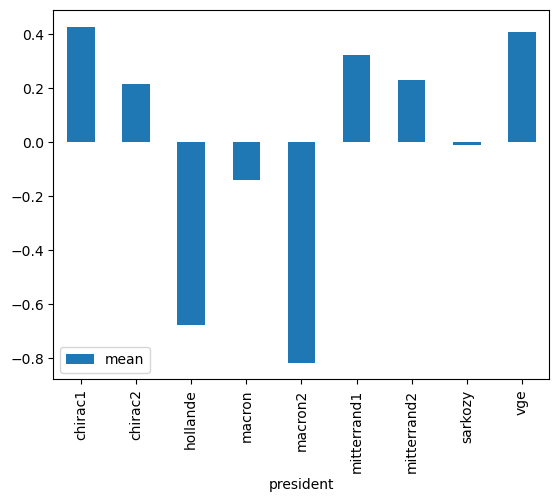

In [19]:
df = pd.DataFrame()

df = pd.DataFrame()
df['mean'] = idata.posterior['president_effect'].mean(axis=0).mean(axis=0).values
df['president'] = idata.posterior['president_effect'].president.values

df.groupby('president').mean().plot(kind="bar")

<Axes: xlabel='week'>

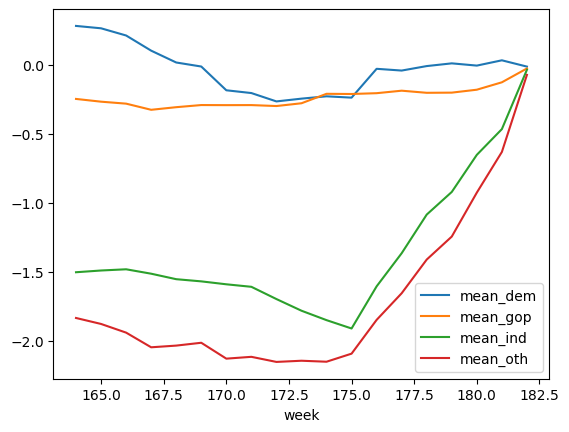

In [1207]:
df_post = pd.DataFrame()
df_post['mean_dem'] = idata.posterior['dem_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_gop'] = idata.posterior['gop_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_ind'] = idata.posterior['ind_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_oth'] = idata.posterior['oth_week_effect'].mean(axis=0).mean(axis=0).values
df_post['week'] = idata.posterior.week.values

df_post.groupby('week').mean().plot()

In [960]:
def plot_latent_mu(inference_data, overlay_observed=True):
    """Plot latent posterior popularity"""
    post_pop = logistic(
        inference_data.posterior["dem_week_effect"].stack(sample=("chain", "draw"))
    )

    fig, ax = plt.subplots()

    # plot random posterior draws
    ax.plot(
        inference_data.posterior.coords["week"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )

    # plot posterior mean
    post_pop.mean("sample").plot(ax=ax, color="black", lw=2, label="predicted mean")

    ax.set_xlabel("Months into term")
    ax.set_ylabel("Does approve")
    ax.legend()

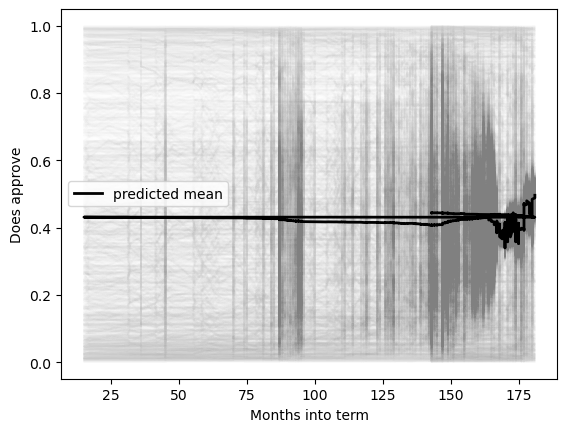

In [961]:
plot_latent_mu(idata)

In [23]:
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: float = 1.0,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters

    name: str
        String name representation of the PyMC variable.
    sigma: float, defaults to 1
        Scale for the Normal distribution. If none is provided, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.

    Notes
-   ----------
    Contributed by Adrian Seyboldt (@aseyboldt).
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncated_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncated_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncated_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_hh(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

COORDS["month_minus_origin"] = COORDS["month"][1:]

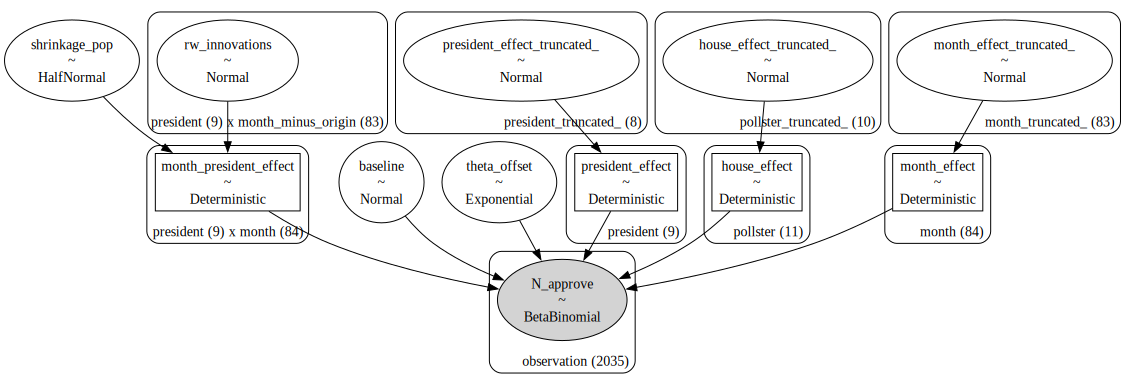

In [24]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = ZeroSumNormal("president_effect", sigma=0.15, dims="president")
    house_effect = ZeroSumNormal("house_effect", sigma=0.15, dims="pollster")
    month_effect = ZeroSumNormal("month_effect", sigma=0.15, dims="month")

    # need the cumsum parametrization to properly control the init of the GRW
    rw_init = aet.zeros(shape=(len(COORDS["president"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("president", "month_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.Deterministic(
        "month_president_effect", raw_rw * sd, dims=("president", "month")
    )

    popularity = pm.math.invlogit(
        baseline
        + president_effect[president_id]
        + month_effect[month_id]
        + month_president_effect[president_id, month_id]
        + house_effect[pollster_id]
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_approve = pm.BetaBinomial(
        "N_approve",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )
pm.model_to_graphviz(hierarchical_popularity)

In [25]:
with hierarchical_popularity:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, president_effect_truncated_, house_effect_truncated_, month_effect_truncated_, rw_innovations, shrinkage_pop, theta_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 267 seconds.


/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


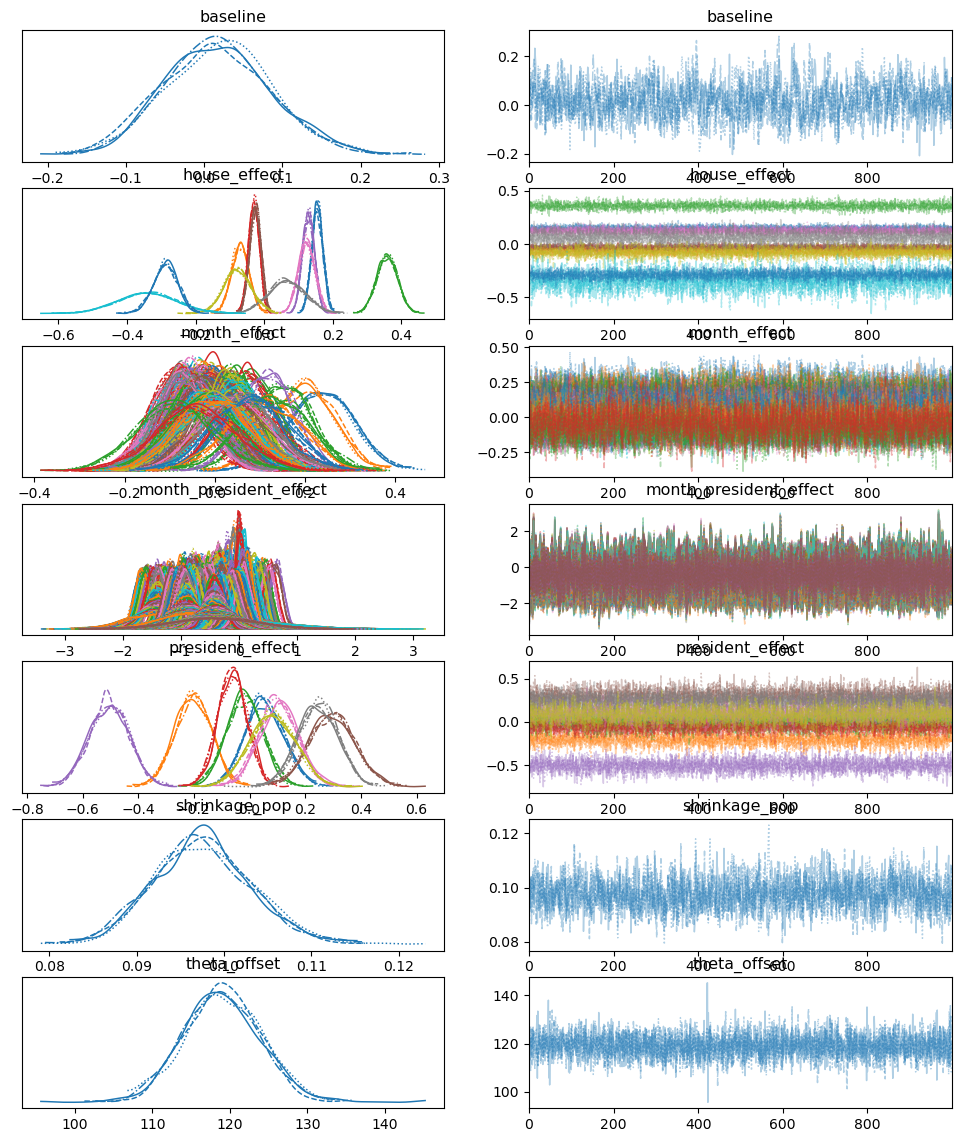

In [26]:
arviz.plot_trace(
    idata,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
    compact=True,
);

In [27]:
arviz.summary(
    idata,
    round_to=2,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (n

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,0.02,0.07,-0.11,0.15,0.00,0.00,894.76,1653.80,1.0
house_effect[BVA],0.16,0.02,0.13,0.19,0.00,0.00,2700.10,2782.97,1.0
house_effect[Elabe],-0.07,0.03,-0.12,-0.02,0.00,0.00,4202.10,3294.66,1.0
house_effect[Harris],0.36,0.03,0.30,0.41,0.00,0.00,4574.67,3096.85,1.0
house_effect[Ifop],-0.03,0.02,-0.06,-0.00,0.00,0.00,2039.60,2604.14,1.0
...,...,...,...,...,...,...,...,...,...
president_effect[mitterrand2],0.10,0.07,-0.03,0.23,0.00,0.00,3553.36,2782.25,1.0
president_effect[sarkozy],0.25,0.07,0.12,0.38,0.00,0.00,3302.49,2867.73,1.0
president_effect[vge],0.08,0.08,-0.07,0.23,0.00,0.00,3841.99,3203.38,1.0
shrinkage_pop,0.10,0.01,0.09,0.11,0.00,0.00,1359.82,2468.22,1.0


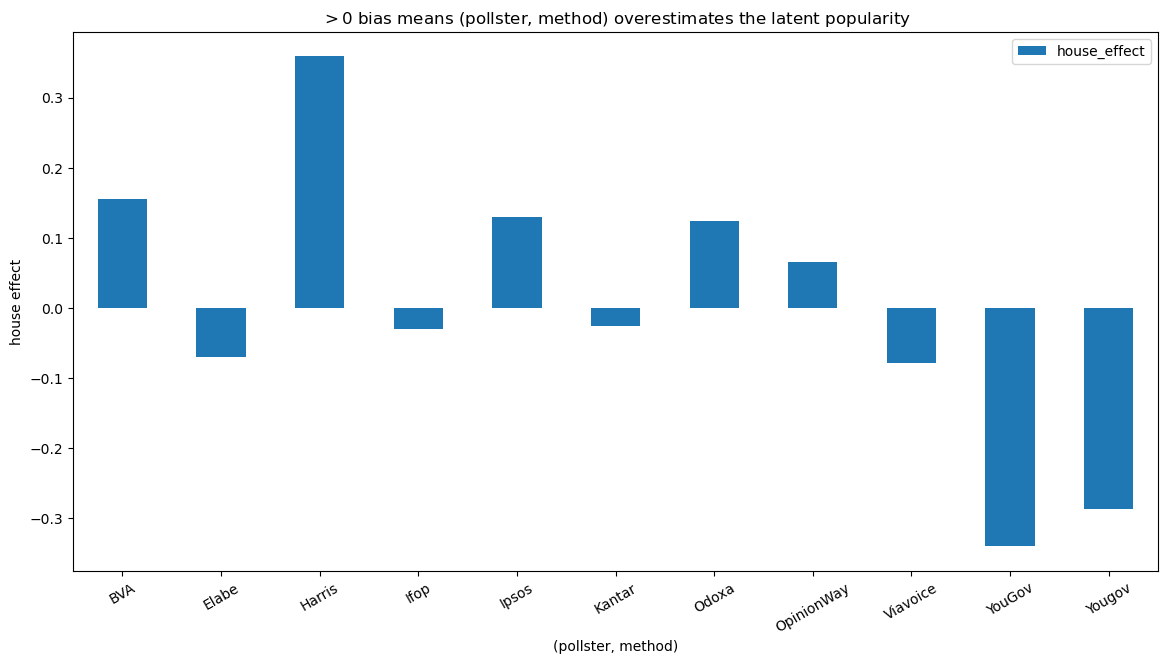

In [28]:
mean_house_effect = (
    idata.posterior["house_effect"].mean(("chain", "draw")).to_dataframe()
)
ax = mean_house_effect.plot.bar(figsize=(14, 7), rot=30)
ax.set_xlabel("(pollster, method)")
ax.set_ylabel("house effect")
ax.set_title("$>0$ bias means (pollster, method) overestimates the latent popularity");


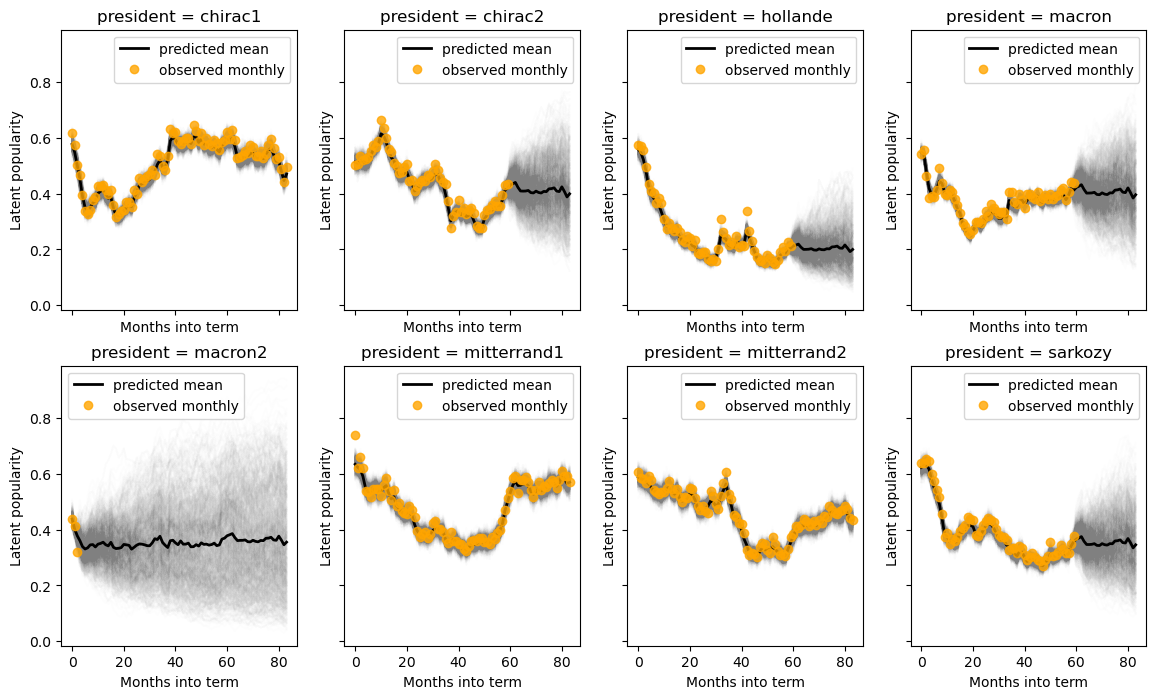

In [29]:
obs_mean = (data.groupby(["president", "month_id"]).last()["approve_pr_mean"]/100).unstack().T

fig, axes = plt.subplots(2, 4, figsize=(14, 8), sharex=True, sharey=True)

for ax, p in zip(axes.ravel(), idata.posterior.coords["president"]):
    post = idata.posterior.sel(president=p)
    post_pop = logistic(
        (
            post["baseline"]
            + post["president_effect"]
            + post["month_effect"]
            + post["month_president_effect"]
        ).stack(sample=("chain", "draw"))
    )
    # plot random posterior draws
    ax.plot(
        post.coords["month"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )
    # plot posterior mean
    post_pop.mean("sample").plot(ax=ax, color="black", lw=2, label="predicted mean")
    # plot monthly raw polls
    ax.plot(
        obs_mean.index,
        obs_mean[p.data],
        "o",
        color="orange",
        alpha=0.8,
        label="observed monthly",
    )
    ax.set_xlabel("Months into term")
    ax.set_ylabel("Latent popularity")
    ax.legend()